# Baseline model: Africa data
- Import excel file, add date column and export it as json. Use json file for analysis
- Data formatting: column names 
- Filter data since 2010
- Function to plot specific country
- Encode event_type and sub_event_type
- Aggregate by month. Working dataset for ML

In [1]:
# African dataset
# https://www.acleddata.com/curated-data-files/

In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Exporting excel file as json

In [4]:
# # import excel file
# df = pd.read_excel('../data/Africa_1997-2019_Oct12-1.xlsx')

In [5]:
# # New column for date & month
# df['date'] = pd.to_datetime(df['EVENT_DATE']).dt.date

In [6]:
# # export dataframe as json
# df.to_json('../data/africa-data.json')

## Importing data

In [7]:
df = pd.read_json('../data/africa-data.json')

In [8]:
df.shape

(193565, 30)

In [9]:
# df.head()

## Data formatting
- Rename columns
- Encode values
- Define classification according to event/fatalities?

In [10]:
# Rename and remove columns
columns = ['YEAR', 'EVENT_TYPE', 'SUB_EVENT_TYPE', 'ACTOR1', 'REGION', 'COUNTRY', 'SOURCE', 'FATALITIES', 'date']
try:
    df = df[columns]
    df.columns = ['year', 'event_type', 'sub_event_type', 'actor', 'region', 'country', 'source', 'fatalities', 'date']
except KeyError as e:
    print(e)
    pass

print(df.columns)
print(df.shape)

Index(['year', 'event_type', 'sub_event_type', 'actor', 'region', 'country', 'source', 'fatalities', 'date'], dtype='object')
(193565, 9)


In [11]:
# Encode event_types and sub_event_types
# https://www.datacamp.com/community/tutorials/categorical-data

In [12]:
# print('**Categorical values**\n')
# print('{} event types:\n {}\n'.format(df.event_type.nunique(), df.event_type.unique()))
# print('{} sub_event types:\n {}\n'.format(df.sub_event_type.nunique(), df.sub_event_type.unique()))
# print('{} actors:\n {}\n'.format(df.actor.nunique(), df.actor.unique()))
# print('{} countries:\n {}\n'.format(df.country.nunique(), df.country.unique()))

## Plot data for a specific country
- Filter data since 2010
- Resample data by year
- Pivot table to plot all data
- Function> Filter data by specific country, aggregate by year. Plot

In [13]:
# Include data since 2010
filtered_data = df[df.year > 2009]
filtered_data['year'].unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

In [14]:
# Group by data by date, resample by year, set date as index
all_data = filtered_data.groupby(['date'])['event_type'].count()
all_data_year = all_data.resample('Y').sum()
all_data_year.index = pd.to_datetime(all_data_year.index)

In [15]:
all_data_year.index

DatetimeIndex(['2010-12-31', '2011-12-31', '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31', '2017-12-31', '2018-12-31', '2019-12-31'], dtype='datetime64[ns]', name='date', freq='A-DEC')

In [16]:
# Pivot table to display all data by country, year, event count

all_countries = filtered_data.groupby(['year', 'country'])['event_type'].count().\
                reset_index(level=['year','country'])

all_countries = pd.pivot_table(all_countries, index= 'year', columns='country', values = 'event_type')


# Graph
# plt.rcParams['figure.figsize'] = (20, 10)
# all_countries.plot(subplots = False, style='-', alpha=0.3, color = 'gray')
# plt.legend().remove()

In [17]:
# print(worst_country.loc[worst_country['event_type'].idxmax()])
# # print('\n')
# # print(worst_country.loc[worst_country['event_type'].min()])
# print(worst_country.loc[worst_country['event_type'].max(level = 'year')])

In [18]:
#Function to get data for one specific country.
# Plot data in a timeline. 

def country_data(data, name_country = ""):
    global df_country
    try:
        #Query and group data by specified country
        df_country = data.query('country == "{}"'.format(name_country))      
        fatalities = df_country.groupby(['date'])['fatalities'].sum()  
        event_type = df_country.groupby(['date'])['event_type'].count()
                
        #matplotlib graph: All cases over time, rolling for country & total
        plt.rcParams['figure.figsize'] = (20, 12)        
        all_countries.plot(subplots=False, style='-', alpha=0.2, color = 'gray')
        all_countries[name_country].plot(subplots=False, style='--', linewidth = 2, alpha=1, color = 'r')
        plt.legend().remove()
        
        print('\n(Data from {} countries)'.format(all_countries.index.nunique()))

        plt.title('{} of events in {} ({} fatalities) (2010 - 2019)\n'.\
              format(df_country['event_type'].count(), name_country, df_country.fatalities.sum()))
        
        plt.xlabel('Tears')
        plt.ylabel('Fatalities')

              
    except (NameError, KeyError) as e:
        print('Error: {}'.format(e))
        plt.legend().remove()
        pass



(Data from 10 countries)


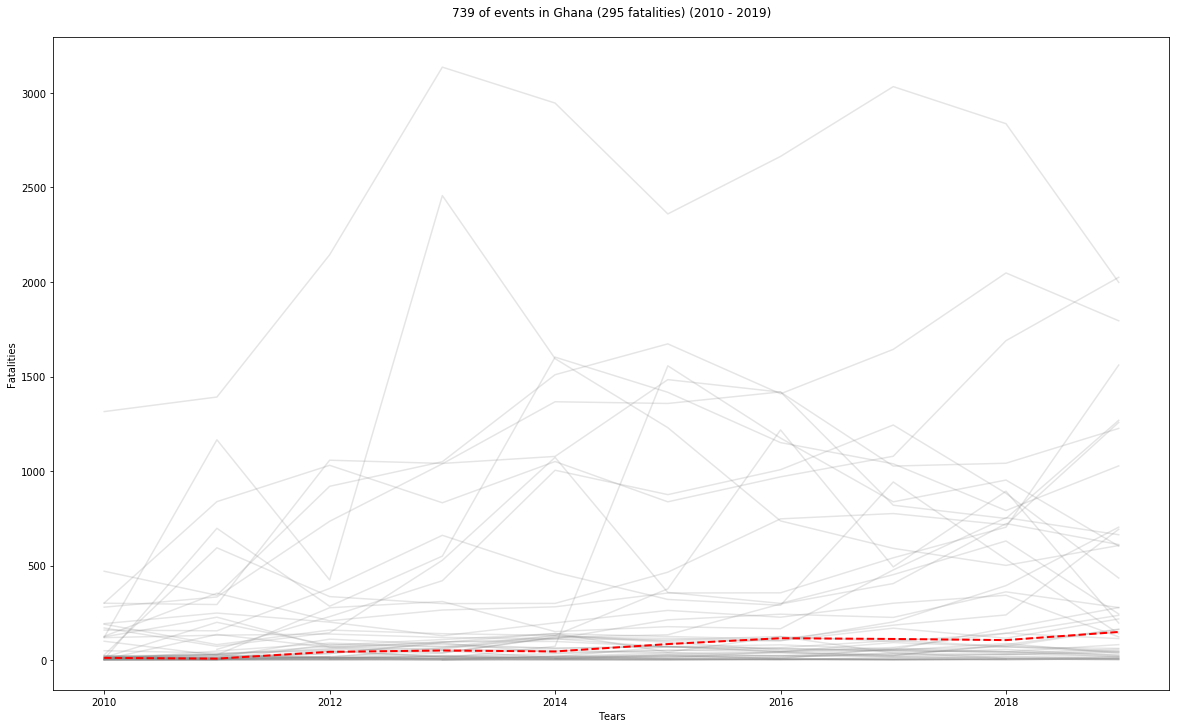

In [19]:
country_data(filtered_data, 'Ghana')

# ML models
- K-clustering for all countries

## Encoding data for all countries since 2010

In [20]:
# Encoding labels
# Selecting labels for encoding in baseline model
labels = ['event_type','sub_event_type', 'country']
labels = filtered_data[labels]
labels.head()

,event_type,sub_event_type,country
10050,Violence against civilians,Attack,Angola
10051,Battles,Armed clash,Angola
10052,Violence against civilians,Attack,Angola
10053,Violence against civilians,Attack,Angola
10054,Violence against civilians,Sexual violence,Angola


In [21]:
# Adding a boolean column for fatalities
filtered_data['fatalities_encoded'] = np.where(filtered_data['fatalities']>0, '1', '0')

/Users/cmserna/Sites/virtualenvs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
# One-Hot Encoding with get_dummies
labels_encoded = pd.get_dummies(labels)

In [23]:
labels_encoded.head()

,event_type_Battles,event_type_Explosions/Remote violence,event_type_Protests,event_type_Riots,event_type_Strategic developments,event_type_Violence against civilians,sub_event_type_Abduction/forced disappearance,sub_event_type_Agreement,sub_event_type_Air/drone strike,sub_event_type_Armed clash,sub_event_type_Arrests,sub_event_type_Attack,sub_event_type_Change to group/activity,sub_event_type_Chemical weapon,sub_event_type_Disrupted weapons use,sub_event_type_Excessive force against protesters,sub_event_type_Government regains territory,sub_event_type_Grenade,sub_event_type_Headquarters or base established,sub_event_type_Looting/property destruction,sub_event_type_Mob violence,sub_event_type_Non-state actor overtakes territory,sub_event_type_Non-violent transfer of territory,sub_event_type_Other,sub_event_type_Peaceful protest,sub_event_type_Protest with intervention,sub_event_type_Remote explosive/landmine/IED,sub_event_type_Sexual violence,sub_event_type_Shelling/artillery/missile attack,sub_event_type_Suicide bomb,sub_event_type_Violent demonstration,country_Algeria,country_Angola,country_Benin,country_Botswana,country_Burkina Faso,country_Burundi,country_Cameroon,country_Central African Republic,country_Chad,country_Democratic Republic of Congo,country_Djibouti,country_Egypt,country_Equatorial Guinea,country_Eritrea,country_Ethiopia,country_Gabon,country_Gambia,country_Ghana,country_Guinea,country_Guinea-Bissau,country_Ivory Coast,country_Kenya,country_Lesotho,country_Liberia,country_Libya,country_Madagascar,country_Malawi,country_Mali,country_Mauritania,country_Morocco,country_Mozambique,country_Namibia,country_Niger,country_Nigeria,country_Republic of Congo,country_Rwanda,country_Senegal,country_Sierra Leone,country_Somalia,country_South Africa,country_South Sudan,country_Sudan,country_Tanzania,country_Togo,country_Tunisia,country_Uganda,country_Zambia,country_Zimbabwe,country_eSwatini
10050,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10051,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10052,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10053,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10054,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
# Dataset with labels + encoded columns
all_labels = pd.concat([labels, labels_encoded], axis=1, sort=False)


In [25]:
all_labels.columns

Index(['event_type', 'sub_event_type', 'country', 'event_type_Battles', 'event_type_Explosions/Remote violence', 'event_type_Protests', 'event_type_Riots', 'event_type_Strategic developments', 'event_type_Violence against civilians', 'sub_event_type_Abduction/forced disappearance', 'sub_event_type_Agreement', 'sub_event_type_Air/drone strike', 'sub_event_type_Armed clash', 'sub_event_type_Arrests', 'sub_event_type_Attack', 'sub_event_type_Change to group/activity', 'sub_event_type_Chemical weapon', 'sub_event_type_Disrupted weapons use', 'sub_event_type_Excessive force against protesters', 'sub_event_type_Government regains territory', 'sub_event_type_Grenade', 'sub_event_type_Headquarters or base established', 'sub_event_type_Looting/property destruction', 'sub_event_type_Mob violence', 'sub_event_type_Non-state actor overtakes territory', 'sub_event_type_Non-violent transfer of territory', 'sub_event_type_Other', 'sub_event_type_Peaceful protest',
       'sub_event_type_Protest with 

In [27]:
filtered_data = pd.concat([filtered_data, labels_encoded], axis = 1, sort = False)
# filtered_data.iloc[1]

## K-clustering all countries
- https://towardsdatascience.com/time-series-of-price-anomaly-detection-13586cd5ff46

In [28]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [29]:
#Check if the are any null values in data
filtered_data.isnull().values.any()
# print(df.isnull().sum())

False

In [30]:
# Select X values 
n = len(filtered_data.columns)
X_fatalities = filtered_data.iloc[:,np.r_[0,7,9:n]]
X = filtered_data.iloc[:,np.r_[0,9:n]] #removing number of fatalities

In [ ]:
# X.head()
# X_fatalities.head()

In [31]:
# Function to select number of clusters
# Using k-means

def n_clusters(data, number, title):
    n_cluster = range(1, number)
    kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
    scores = [kmeans[i].score(data) for i in range(len(kmeans))]
    
    fig, ax = plt.subplots(figsize=(10,7))
    ax.plot(n_cluster, scores)
    plt.xlabel('Number of Clusters: {}'.format(title))
    plt.ylabel('Score')
    plt.title('Elbow Curve')
    plt.show()
    

In [39]:
# Function to assigng clusters
def clustering(data, number_clusters):
    clusters = KMeans(n_clusters=number_clusters)    
    clusters.fit(data)
    data['labels'] = clusters.predict(data)
                    

### K-clustering with fatalities number
- Dataset: X_fatalities

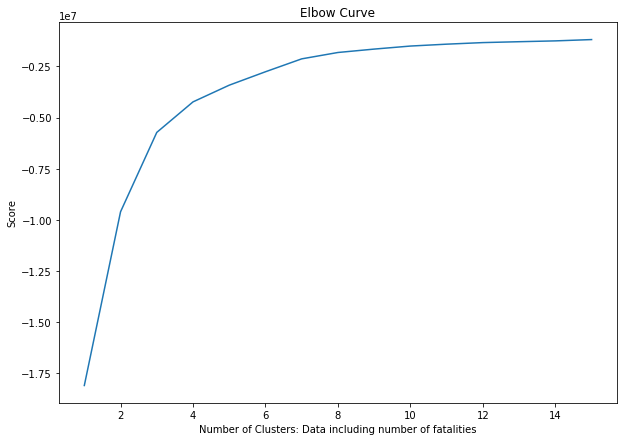

In [32]:
# Cluster for data including number of fatalities
n_clusters(X_fatalities, 16, "Data including number of fatalities")

In [40]:
clustering(X_fatalities, 10)

/Users/cmserna/Sites/virtualenvs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [41]:
filtered_data['X_fatalities_labels'] = X_fatalities['labels']

In [42]:
filtered_data.X_fatalities_labels.value_counts()

7    51765
0    45535
6    33275
9     9257
4     2406
2      775
8      234
3       64
1       32
5       11
Name: X_fatalities_labels, dtype: int64

In [43]:
filtered_data[filtered_data.X_fatalities_labels == 5]

,year,event_type,sub_event_type,actor,region,country,source,fatalities,date,fatalities_encoded,event_type_Battles,event_type_Explosions/Remote violence,event_type_Protests,event_type_Riots,event_type_Strategic developments,event_type_Violence against civilians,sub_event_type_Abduction/forced disappearance,sub_event_type_Agreement,sub_event_type_Air/drone strike,sub_event_type_Armed clash,sub_event_type_Arrests,sub_event_type_Attack,sub_event_type_Change to group/activity,sub_event_type_Chemical weapon,sub_event_type_Disrupted weapons use,sub_event_type_Excessive force against protesters,sub_event_type_Government regains territory,sub_event_type_Grenade,sub_event_type_Headquarters or base established,sub_event_type_Looting/property destruction,sub_event_type_Mob violence,sub_event_type_Non-state actor overtakes territory,sub_event_type_Non-violent transfer of territory,sub_event_type_Other,sub_event_type_Peaceful protest,sub_event_type_Protest with intervention,sub_event_type_Remote explosive/landmine/IED,sub_event_type_Sexual violence,sub_event_type_Shelling/artillery/missile attack,sub_event_type_Suicide bomb,sub_event_type_Violent demonstration,country_Algeria,country_Angola,country_Benin,country_Botswana,country_Burkina Faso,country_Burundi,country_Cameroon,country_Central African Republic,country_Chad,country_Democratic Republic of Congo,country_Djibouti,country_Egypt,country_Equatorial Guinea,country_Eritrea,country_Ethiopia,country_Gabon,country_Gambia,country_Ghana,country_Guinea,country_Guinea-Bissau,country_Ivory Coast,country_Kenya,country_Lesotho,country_Liberia,country_Libya,country_Madagascar,country_Malawi,country_Mali,country_Mauritania,country_Morocco,country_Mozambique,country_Namibia,country_Niger,country_Nigeria,country_Republic of Congo,country_Rwanda,country_Senegal,country_Sierra Leone,country_Somalia,country_South Africa,country_South Sudan,country_Sudan,country_Tanzania,country_Togo,country_Tunisia,country_Uganda,country_Zambia,country_Zimbabwe,country_eSwatini,event_type_Battles,event_type_Explosions/Remote violence,event_type_Protests,event_type_Riots,event_type_Strategic developments,event_type_Violence against civilians,sub_event_type_Abduction/forced disappearance,sub_event_type_Agreement,sub_event_type_Air/drone strike,sub_event_type_Armed clash,sub_event_type_Arrests,sub_event_type_Attack,sub_event_type_Change to group/activity,sub_event_type_Chemical weapon,sub_event_type_Disrupted weapons use,sub_event_type_Excessive force against protesters,sub_event_type_Government regains territory,sub_event_type_Grenade,sub_event_type_Headquarters or base established,sub_event_type_Looting/property destruction,sub_event_type_Mob violence,sub_event_type_Non-state actor overtakes territory,sub_event_type_Non-violent transfer of territory,sub_event_type_Other,sub_event_type_Peaceful protest,sub_event_type_Protest with intervention,sub_event_type_Remote explosive/landmine/IED,sub_event_type_Sexual violence,sub_event_type_Shelling/artillery/missile attack,sub_event_type_Suicide bomb,sub_event_type_Violent demonstration,country_Algeria,country_Angola,country_Benin,country_Botswana,country_Burkina Faso,country_Burundi,country_Cameroon,country_Central African Republic,country_Chad,country_Democratic Republic of Congo,country_Djibouti,country_Egypt,country_Equatorial Guinea,country_Eritrea,country_Ethiopia,country_Gabon,country_Gambia,country_Ghana,country_Guinea,country_Guinea-Bissau,country_Ivory Coast,country_Kenya,country_Lesotho,country_Liberia,country_Libya,country_Madagascar,country_Malawi,country_Mali,country_Mauritania,country_Morocco,country_Mozambique,country_Namibia,country_Niger,country_Nigeria,country_Republic of Congo,country_Rwanda,country_Senegal,country_Sierra Leone,country_Somalia,country_South Africa,country_South Sudan,country_Sudan,country_Tanzania,country_Togo,country_Tunisia,country_Uganda,country_Zambia,country_Zimbabwe,country_eSwatini,X_fatalities_labels
125875,2017,Explosions/Remote viole

### K-clustering without numbers of fatalities
- Data: X

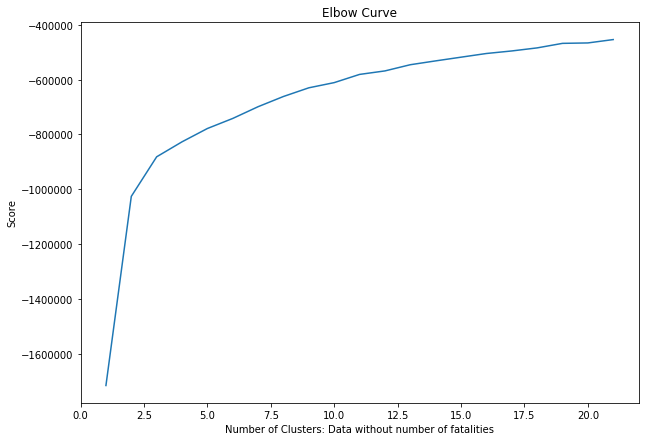

In [44]:
# n_clusterss for data without number of fatalities
n_clusters(X, 22, "Data without number of fatalities")

In [45]:
# K-clustering with fatalities number
clustering(X, 20)

/Users/cmserna/Sites/virtualenvs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [46]:
filtered_data['X_labels'] = X['labels']

In [49]:
filtered_data.X_labels.value_counts()

19    12519
5     11018
4      9675
9      8462
0      8314
10     8193
6      8143
11     8001
3      7621
13     7422
15     7096
17     6589
12     6571
7      6039
1      5596
16     5151
18     4906
8      4357
2      3885
14     3796
Name: X_labels, dtype: int64

In [55]:
filtered_data[filtered_data.X_labels == 3].sample(5)

,year,event_type,sub_event_type,actor,region,country,source,fatalities,date,fatalities_encoded,event_type_Battles,event_type_Explosions/Remote violence,event_type_Protests,event_type_Riots,event_type_Strategic developments,event_type_Violence against civilians,sub_event_type_Abduction/forced disappearance,sub_event_type_Agreement,sub_event_type_Air/drone strike,sub_event_type_Armed clash,sub_event_type_Arrests,sub_event_type_Attack,sub_event_type_Change to group/activity,sub_event_type_Chemical weapon,sub_event_type_Disrupted weapons use,sub_event_type_Excessive force against protesters,sub_event_type_Government regains territory,sub_event_type_Grenade,sub_event_type_Headquarters or base established,sub_event_type_Looting/property destruction,sub_event_type_Mob violence,sub_event_type_Non-state actor overtakes territory,sub_event_type_Non-violent transfer of territory,sub_event_type_Other,sub_event_type_Peaceful protest,sub_event_type_Protest with intervention,sub_event_type_Remote explosive/landmine/IED,sub_event_type_Sexual violence,sub_event_type_Shelling/artillery/missile attack,sub_event_type_Suicide bomb,sub_event_type_Violent demonstration,country_Algeria,country_Angola,country_Benin,country_Botswana,country_Burkina Faso,country_Burundi,country_Cameroon,country_Central African Republic,country_Chad,country_Democratic Republic of Congo,country_Djibouti,country_Egypt,country_Equatorial Guinea,country_Eritrea,country_Ethiopia,country_Gabon,country_Gambia,country_Ghana,country_Guinea,country_Guinea-Bissau,country_Ivory Coast,country_Kenya,country_Lesotho,country_Liberia,country_Libya,country_Madagascar,country_Malawi,country_Mali,country_Mauritania,country_Morocco,country_Mozambique,country_Namibia,country_Niger,country_Nigeria,country_Republic of Congo,country_Rwanda,country_Senegal,country_Sierra Leone,country_Somalia,country_South Africa,country_South Sudan,country_Sudan,country_Tanzania,country_Togo,country_Tunisia,country_Uganda,country_Zambia,country_Zimbabwe,country_eSwatini,event_type_Battles,event_type_Explosions/Remote violence,event_type_Protests,event_type_Riots,event_type_Strategic developments,event_type_Violence against civilians,sub_event_type_Abduction/forced disappearance,sub_event_type_Agreement,sub_event_type_Air/drone strike,sub_event_type_Armed clash,sub_event_type_Arrests,sub_event_type_Attack,sub_event_type_Change to group/activity,sub_event_type_Chemical weapon,sub_event_type_Disrupted weapons use,sub_event_type_Excessive force against protesters,sub_event_type_Government regains territory,sub_event_type_Grenade,sub_event_type_Headquarters or base established,sub_event_type_Looting/property destruction,sub_event_type_Mob violence,sub_event_type_Non-state actor overtakes territory,sub_event_type_Non-violent transfer of territory,sub_event_type_Other,sub_event_type_Peaceful protest,sub_event_type_Protest with intervention,sub_event_type_Remote explosive/landmine/IED,sub_event_type_Sexual violence,sub_event_type_Shelling/artillery/missile attack,sub_event_type_Suicide bomb,sub_event_type_Violent demonstration,country_Algeria,country_Angola,country_Benin,country_Botswana,country_Burkina Faso,country_Burundi,country_Cameroon,country_Central African Republic,country_Chad,country_Democratic Republic of Congo,country_Djibouti,country_Egypt,country_Equatorial Guinea,country_Eritrea,country_Ethiopia,country_Gabon,country_Gambia,country_Ghana,country_Guinea,country_Guinea-Bissau,country_Ivory Coast,country_Kenya,country_Lesotho,country_Liberia,country_Libya,country_Madagascar,country_Malawi,country_Mali,country_Mauritania,country_Morocco,country_Mozambique,country_Namibia,country_Niger,country_Nigeria,country_Republic of Congo,country_Rwanda,country_Senegal,country_Sierra Leone,country_Somalia,country_South Africa,country_South Sudan,country_Sudan,country_Tanzania,country_Togo,country_Tunisia,country_Uganda,country_Zambia,country_Zimbabwe,country_eSwatini,X_fatalities_labels,X_labels
87352,2015,Violence agains

### Visualize clusters using PCA components

In [57]:
# PCA for X: data without fatalities
pca = PCA(n_components=2)
# X_principalComponents = pca.fit_transform(X)
X_principal = pd.DataFrame(data = pca.fit_transform(X), columns = ['PCA 1', 'PCA2 2'])
X_principal.columns

Index(['PCA 1', 'PCA2 2'], dtype='object')

In [67]:
# X_principal.plot.scatter('PCA 1', 'PCA2 2', alpha = 0.5)

In [63]:
# Run new clusters based on PCA components
clustering(X_principal, 2)

In [72]:
filtered_data['pca1'] = X_principal['PCA 1']
filtered_data['pca2'] = X_principal['PCA2 2']
filtered_data.head()

,year,event_type,sub_event_type,actor,region,country,source,fatalities,date,fatalities_encoded,event_type_Battles,event_type_Explosions/Remote violence,event_type_Protests,event_type_Riots,event_type_Strategic developments,event_type_Violence against civilians,sub_event_type_Abduction/forced disappearance,sub_event_type_Agreement,sub_event_type_Air/drone strike,sub_event_type_Armed clash,sub_event_type_Arrests,sub_event_type_Attack,sub_event_type_Change to group/activity,sub_event_type_Chemical weapon,sub_event_type_Disrupted weapons use,sub_event_type_Excessive force against protesters,sub_event_type_Government regains territory,sub_event_type_Grenade,sub_event_type_Headquarters or base established,sub_event_type_Looting/property destruction,sub_event_type_Mob violence,sub_event_type_Non-state actor overtakes territory,sub_event_type_Non-violent transfer of territory,sub_event_type_Other,sub_event_type_Peaceful protest,sub_event_type_Protest with intervention,sub_event_type_Remote explosive/landmine/IED,sub_event_type_Sexual violence,sub_event_type_Shelling/artillery/missile attack,sub_event_type_Suicide bomb,sub_event_type_Violent demonstration,country_Algeria,country_Angola,country_Benin,country_Botswana,country_Burkina Faso,country_Burundi,country_Cameroon,country_Central African Republic,country_Chad,country_Democratic Republic of Congo,country_Djibouti,country_Egypt,country_Equatorial Guinea,country_Eritrea,country_Ethiopia,country_Gabon,country_Gambia,country_Ghana,country_Guinea,country_Guinea-Bissau,country_Ivory Coast,country_Kenya,country_Lesotho,country_Liberia,country_Libya,country_Madagascar,country_Malawi,country_Mali,country_Mauritania,country_Morocco,country_Mozambique,country_Namibia,country_Niger,country_Nigeria,country_Republic of Congo,country_Rwanda,country_Senegal,country_Sierra Leone,country_Somalia,country_South Africa,country_South Sudan,country_Sudan,country_Tanzania,country_Togo,country_Tunisia,country_Uganda,country_Zambia,country_Zimbabwe,country_eSwatini,event_type_Battles,event_type_Explosions/Remote violence,event_type_Protests,event_type_Riots,event_type_Strategic developments,event_type_Violence against civilians,sub_event_type_Abduction/forced disappearance,sub_event_type_Agreement,sub_event_type_Air/drone strike,sub_event_type_Armed clash,sub_event_type_Arrests,sub_event_type_Attack,sub_event_type_Change to group/activity,sub_event_type_Chemical weapon,sub_event_type_Disrupted weapons use,sub_event_type_Excessive force against protesters,sub_event_type_Government regains territory,sub_event_type_Grenade,sub_event_type_Headquarters or base established,sub_event_type_Looting/property destruction,sub_event_type_Mob violence,sub_event_type_Non-state actor overtakes territory,sub_event_type_Non-violent transfer of territory,sub_event_type_Other,sub_event_type_Peaceful protest,sub_event_type_Protest with intervention,sub_event_type_Remote explosive/landmine/IED,sub_event_type_Sexual violence,sub_event_type_Shelling/artillery/missile attack,sub_event_type_Suicide bomb,sub_event_type_Violent demonstration,country_Algeria,country_Angola,country_Benin,country_Botswana,country_Burkina Faso,country_Burundi,country_Cameroon,country_Central African Republic,country_Chad,country_Democratic Republic of Congo,country_Djibouti,country_Egypt,country_Equatorial Guinea,country_Eritrea,country_Ethiopia,country_Gabon,country_Gambia,country_Ghana,country_Guinea,country_Guinea-Bissau,country_Ivory Coast,country_Kenya,country_Lesotho,country_Liberia,country_Libya,country_Madagascar,country_Malawi,country_Mali,country_Mauritania,country_Morocco,country_Mozambique,country_Namibia,country_Niger,country_Nigeria,country_Republic of Congo,country_Rwanda,country_Senegal,country_Sierra Leone,country_Somalia,country_South Africa,country_South Sudan,country_Sudan,country_Tanzania,country_Togo,country_Tunisia,country_Uganda,country_Zambia,country_Zimbabwe,country_eSwatini,X_fatalities_labels,X_labels,X_principal,pca1,pca2
1005

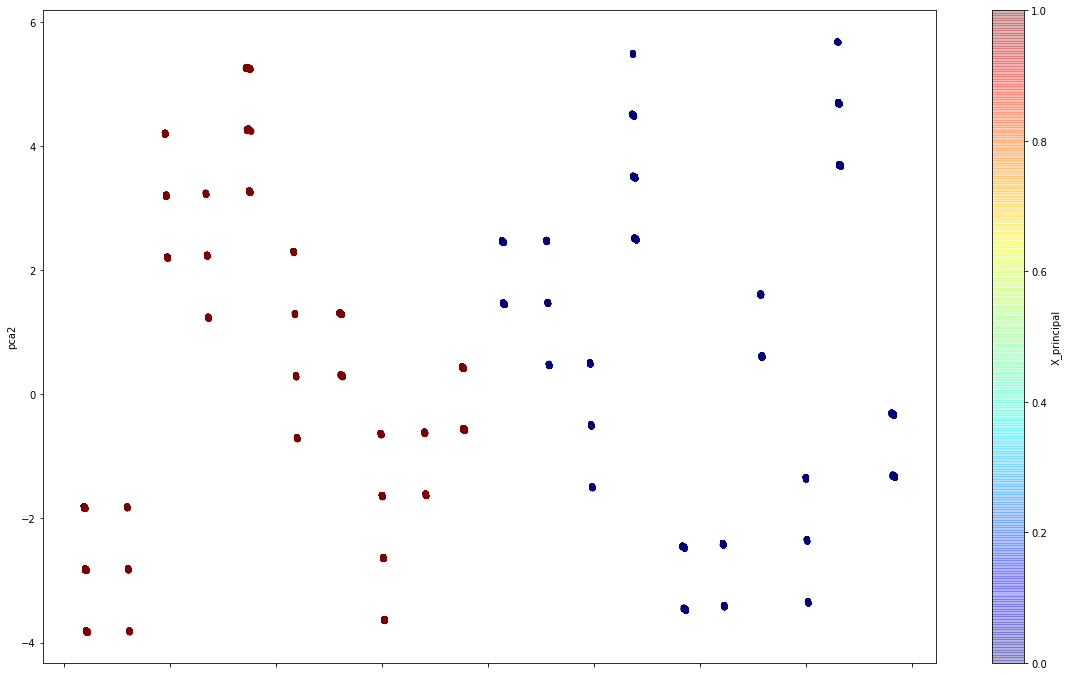

In [97]:
filtered_data.plot.scatter('pca1', 'pca2', alpha = 0.3, c='X_principal', colormap='jet')

In [98]:
# filtered_data.plot(x = 'date', y='labels', figsize=(20, 10), style='.', alpha=0.1)
# plt.yticks(np.arange(min(filtered_data.labels), max(filtered_data.labels)+2, 1.0))
# plt.show()

In [ ]:
X.plot.scatter('labels', 'fatalities', c='labels', colormap='jet')
plt.xticks(np.arange(min(X.labels), max(X.labels)+2, 1.0))
plt.show()

In [ ]:
# Use PCA to determine most significatn columns

## Using Random Forest

In [ ]:
# https://www.kaggle.com/adithya44/anomaly-detection-isolation-forest-visualization